# Fluxonium

## Initialization (load modules etc.)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import itertools

import scqubits as qubit
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.constants as const

from qutip import *
from scqubits.utils.spectrum_utils import get_matrixelement_table, matrix_element
from scqubits.utils.sweep_plotting import bare_spectrum, dressed_spectrum, difference_spectrum
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

In [2]:
J_to_GHz = 1. / (2. * np.pi * const.hbar * (10**9))  # (1/(2pi hbar 10^9))
GHz_to_J = 1./J_to_GHz

resonator = qubit.Oscillator(
    E_osc = 5.7286,
    truncated_dim=5
)

fluxonium = qubit.Fluxonium(
    EJ = 3.395,
    EL = 0.132,
    EC = 0.479,
    flux = 0.5,
    cutoff = 110,
    truncated_dim = 60
)

hilbertspc = HilbertSpace([fluxonium, resonator])

adag = resonator.creation_operator()
a = resonator.annihilation_operator()

int_term = InteractionTerm(
    g_strength = 0.076, 
    subsys1 = fluxonium, 
    op1 = fluxonium.n_operator(), 
    subsys2 = resonator, 
    op2 = a+adag
)

interaction_list = [int_term]
hilbertspc.interaction_list = interaction_list

dressed_hamiltonian = hilbertspc.get_hamiltonian()    

evals, evecs = dressed_hamiltonian.eigenstates(eigvals=10)

In [3]:
param_name = 'flux'                          # name of varying external parameter
param_vals = np.linspace(0.25, 0.5, 100)     # parameter values

subsys_update_list = [fluxonium]                  # list of HilbertSpace subsystems which are affected by parameter changes         

def update_hilbertspace(param_val):     # function that shows how Hilbert space components are updated
    fluxonium.flux = param_val
    
sweep = ParameterSweep(
    param_name=param_name,
    param_vals=param_vals,
    evals_count=50,
    hilbertspace=hilbertspc,
    subsys_update_list=subsys_update_list,
    update_hilbertspace=update_hilbertspace
)


(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a26c75d68>)

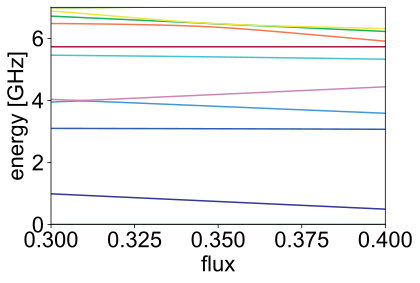

In [4]:
dressed_spectrum(sweep, xlim=(0.3,0.4),ylim=(0,7))

In [5]:
temp=0.05

def nthermal(omega):
    return(1./(np.exp(omega*GHz_to_J/(const.k*temp))-1.))

def Pthermalprob(n, resonator):
    return((1-np.exp(-resonator.E_osc*GHz_to_J/(const.k*temp)))
           *np.exp(-n*resonator.E_osc*GHz_to_J/(const.k*temp)))
        
def gamma_purcell_sweep_old(i, j, sweep, kappa, k, flux_val):
    #i -> j
    evals_dressed, evecs_dressed = sweep.dressed_specdata.energy_table[k], sweep.dressed_specdata.state_table[k]
    fluxonium.flux = flux_val
    evals_fluxonium, evecs_fluxonium = fluxonium.eigensys(evals_count=20)
    gammap = 0.0
    if (evals_fluxonium[i] > evals_fluxonium[j]):
        #n1 ranges over initial states of the resonator
        for n1 in range(2):
            #n2 over final
            for n2 in range(2):
                indexin1 = sweep.lookup.dressed_index((i,n1), param_index=k)
                indexjn2 = sweep.lookup.dressed_index((j,n2), param_index=k)
                gammap += (Pthermalprob(n1, resonator)
                           *np.abs(matrix_element(evecs_dressed[indexjn2],
                                                  sweep.hilbertspace.identity_wrap(resonator.annihilation_operator(),
                                                                                   resonator),evecs_dressed[indexin1]))**2)
        omegaij = evals_fluxonium[i]-evals_fluxonium[j]
        return(10**9 * kappa * (nthermal(omegaij) + 1) * gammap)
    else:
        #n1 ranges over initial states of the resonator
        for n1 in range(2):
            #n2 over final
            for n2 in range(2):
                indexin1 = sweep.lookup.dressed_index((i,n1), param_index=k)
                indexjn2 = sweep.lookup.dressed_index((j,n2), param_index=k)
                gammap += (Pthermalprob(n1, resonator)
                            *np.abs(matrix_element(evecs_dressed[indexjn2],
                                                    sweep.hilbertspace.identity_wrap(resonator.creation_operator(),
                                                                                    resonator),evecs_dressed[indexin1]))**2)
        omegaij = evals_fluxonium[j]-evals_fluxonium[i]
        return(10**9 * kappa * (nthermal(omegaij)) * gammap)
            

In [6]:
def gamma_purcell_sweep(i, j, sweep, kappa, k, flux_val):
    #i -> j
    evals_dressed, evecs_dressed = sweep.dressed_specdata.energy_table[k], sweep.dressed_specdata.state_table[k]
    fluxonium.flux = flux_val
    evals_fluxonium, evecs_fluxonium = fluxonium.eigensys(evals_count=20)
    gammap = 0.0
    if (evals_fluxonium[i] > evals_fluxonium[j]):
        for n1 in range(2):
            for n2 in range(2):
                indexin1 = sweep.lookup.dressed_index((i,n1), param_index=k)
                indexjn2 = sweep.lookup.dressed_index((j,n2), param_index=k)
                omegaij = np.abs(evals_dressed[indexin1]-evals_dressed[indexjn2])
                gammap += (Pthermalprob(n1, resonator) * (nthermal(omegaij) + 1)
                           *np.abs(matrix_element(evecs_dressed[indexjn2],
                                                  hilbertspc.identity_wrap(resonator.annihilation_operator(),
                                                                                   resonator),evecs_dressed[indexin1]))**2)
        return(10**9 * kappa * gammap)
    else:
        for n1 in range(2):
            for n2 in range(2):
                indexin1 = sweep.lookup.dressed_index((i,n1), param_index=k)
                indexjn2 = sweep.lookup.dressed_index((j,n2), param_index=k)
                omegaij = np.abs(evals_dressed[indexin1]-evals_dressed[indexjn2])
                gammap += (Pthermalprob(n1, resonator) * (nthermal(omegaij))
                            *np.abs(matrix_element(evecs_dressed[indexjn2],
                                                    hilbertspc.identity_wrap(resonator.creation_operator(),
                                                                                    resonator),evecs_dressed[indexin1]))**2)
        return(10**9 * kappa * gammap)
    

In [7]:
gamma_purcell_list = np.zeros(len(param_vals))
gamma_purcell_0up = np.zeros_like(gamma_purcell_list)
gamma_purcell_1up = np.zeros_like(gamma_purcell_list)
for k, flux_val in enumerate(param_vals):
    gamma_purcell_list[k] = (gamma_purcell_sweep(0,1,sweep,0.00165, k, flux_val)
                             + gamma_purcell_sweep(1,0,sweep,0.00165, k, flux_val))
    #j ranges over higher fluxonium levels
    gamma_purcell_0up[k] = np.sum([gamma_purcell_sweep(0,j,sweep,0.00165,k,flux_val) for j in range(1,15)])
    gamma_purcell_1up[k] = np.sum([gamma_purcell_sweep(1,j,sweep,0.00165,k,flux_val) for j in range(2,15)])
    

In [8]:
blist = np.linspace(0.25, 0.5, 100)
hbard2kb = const.hbar/const.k/2
spect = fluxonium.get_spectrum_vs_paramvals('flux', blist, evals_count=2, subtract_ground=True)
spect_table = spect.energy_table.T[1]*2*np.pi*1e9
wq = spect_table

In [9]:
levls = 8
philist = []
nlist = []
sinphilist = []
for ii in blist:
    fluxonium.flux = ii
    phi = abs((fluxonium.matrixelement_table('phi_operator', evals_count=levls)[0, 1]))**2
    n =  abs((fluxonium.matrixelement_table('n_operator', evals_count=levls)[0, 1]))**2
#     sinphi =  abs((fluxonium.matrixelement_table('sinphi_operator', evals_count=levls)[0, 1]))**2
    philist.append(phi)
    nlist.append(n)
#     sinphilist.append(sinphi)
philist = np.array(philist)
nlist = np.array(nlist)
# sinphilist = np.array(sinphilist)

In [10]:
T_cap = 0.042
EC = 0.479e9*const.h
Gamma_cap = const.hbar*wq*wq/np.tanh(const.hbar*wq/const.k/T_cap/2)*philist/(8*EC/(9e-6))

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.set_yscale('log')
# ax.plot(blist,1/Gamma_cap*1e6)
print(1/Gamma_cap[-1]*1e6)

314.39100694431716


In [18]:
T_ind = 0.042
EL = 0.132e9*const.h
Gamma_ind = 2*EL/const.hbar/np.tanh(const.hbar*wq/const.k/T_ind/2)*philist/(6e8)

# fig, ax = plt.subplots(1,1, figsize=(12,5))
# ax.set_yscale('log')
# ax.plot(blist,1/Gamma_ind*1e6)
print(1/Gamma_ind[-1]*1e6)

323.37830285084874


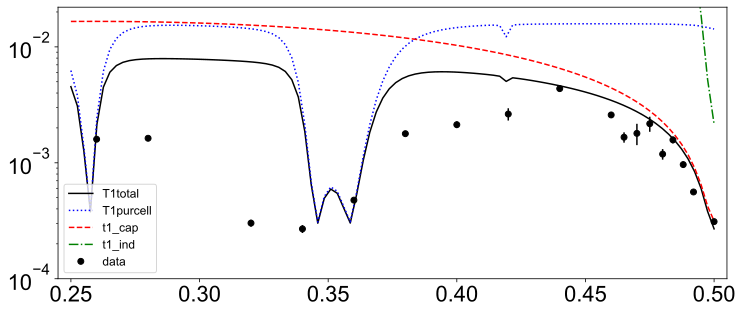

In [16]:
t1_cap = 1/Gamma_cap
t1_ind = 1/Gamma_ind
T1total = 1/(Gamma_cap+Gamma_ind+gamma_purcell_list + gamma_purcell_0up + gamma_purcell_1up)
T1purcell = 1./(gamma_purcell_list + gamma_purcell_0up + gamma_purcell_1up)
T1purcell01 = 1./gamma_purcell_list
T1purcell0up = 1./gamma_purcell_0up
T1purcell1up = 1./gamma_purcell_1up
#T1purcellperturb = 1./gamma_purcell_perturb_list
fig=plt.figure(figsize=(12,5))
plt.yscale("log")
plt.plot(param_vals, T1total, 'k-')
plt.plot(param_vals, T1purcell, 'b:')
# plt.plot(param_vals, T1purcell01, color="yellow")
# plt.plot(param_vals, T1purcell0up, color="red")
# plt.plot(param_vals, T1purcell1up, color="green")

# plt.plot(param_vals, t1_charge, color="orange")
plt.plot(param_vals, t1_cap, "r--")
plt.plot(param_vals, t1_ind, "g-.")
#plt.plot(param_vals, T1purcellperturb, color="purple")
errlist = 10**(-6)*np.array([78.034, 70.57, 20.71, 20.93, 12.92, 66.93, 137.06, 319.19, 
                 194.84, 146.87, 170.584, 374.582, 322.533, 125.10, 105.987, 58.612, 22.295, 11.29])
t1_data = 10**(-6)*np.array([1597.923, 1627.93, 301.86, 269.03, 476.33, 1783.19, 2131.76, 2634.50, 
                   4364.68, 2587.82, 1661.915, 1794.468, 2173.88, 1188.83, 
                   1576.493, 965.183, 560.251, 310.88])
t1_flux = np.array([0.26, 0.28, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.465, 
                   0.47, 0.475, 0.48, 0.484, 0.488, 0.492, 0.5])
plt.errorbar(t1_flux,t1_data,errlist,fmt=' ',ecolor='k')
plt.plot(t1_flux,t1_data,'ko')
# plt.legend(("T1purcell","T1purcell01","T1purcell0up","T1purcell1up","T1total","t1_charge","t1_cap","t1_ind","data"), fontsize=12)
plt.legend(("T1total","T1purcell","t1_cap","t1_ind","data"), fontsize=12)
plt.ylim(10**(-4),2.2*10**(-2))
plt.xlim(0.245,0.505)
# plt.xlabel("flux")
# plt.ylabel("s")
plt.show()
# fig.savefig("T1vsFlux.pdf")